<u><center><br><font size=10>Final Project</font><br></u>
<br><br>
<font size=6>Introduction to Machine Learning – Digital Sciences for High-Tech</font>
<br><br>
<font size=5>Author: Ran Asanta and Eidan Baavur</font>
<br><i>Spring 2023</i></center>

<u><font size=6>Importing the necessary libraries</font></u>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tabulate import tabulate
from typing import List, Dict
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix, roc_curve, accuracy_score
from scipy.spatial.distance import mahalanobis

warnings.filterwarnings('ignore') #Ignroe warnings

c:\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


<u><font size=6>Loading the Dataset</font></u><br>
In addition to loading the dataset we check its feature types.

In [2]:
dataset = pd.read_csv('train.csv')
dataset.dtypes

sha256                  object
size                     int64
vsize                  float64
imports                float64
exports                float64
has_debug              float64
has_relocations        float64
has_resources          float64
has_signature          float64
has_tls                float64
symbols                float64
numstrings             float64
paths                  float64
urls                   float64
registry               float64
MZ                     float64
printables             float64
avlength               float64
file_type_trid          object
file_type_prob_trid    float64
A                      float64
B                      float64
C                       object
label                    int64
dtype: object

<u><font size=6>Benchmark Logistic Regression Model</font></u><br>
We will start by implementing a prior Logistic Regression model that classifies wether a file is malware or not. The results will act as a benchmark for the AUC score and will assist in understanding the efficiency of our pre-processing. 

<u><font size=5>Removing Non-Numerical Features</font></u><br>
In order to do so we will ignore samples with empty values and non-numerical features (binary and categorical features), meaning we will implement the model with the least data processing possible. As you will be able to see, we lost almsot half the samples in this process.

In [3]:
print(dataset.shape)
feat_cat = ['file_type_trid', 'C']
feat_bin = ['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']
feat_non_numeric = feat_cat + feat_bin
df_prior = dataset.drop(feat_non_numeric, axis=1)
df_prior = df_prior.dropna()

print(df_prior.shape)
null_counts_by_column = df_prior.isnull().sum(axis=0) # Checking that there aren't any rows with empty cells 
print(null_counts_by_column)


(60000, 24)
(32557, 17)
sha256                 0
size                   0
vsize                  0
imports                0
exports                0
symbols                0
numstrings             0
paths                  0
urls                   0
registry               0
MZ                     0
printables             0
avlength               0
file_type_prob_trid    0
A                      0
B                      0
label                  0
dtype: int64


<u><font size=5>The Models Function</font></u><br>
We created a function that will assist us during the entire project. The 'print_cv_clf' funtcion implements a model on a given dataset 'X' and its labels 'y'.
The function serves two purposes: 
1. it fits the data and does a 5-fold cross validation, resulting with a Mean Accuracy Score and a Mean ROC-AUC Score for the train set and the validation set.
2. It presents the ROC-Curves of the 5 folds.

This is the way we will inspect the results of every model in this project and deduce which model should predict the Test set the best.

In [4]:
def print_cv_clf(clf, X, y):

    fprs, tprs, thresholds, auc_scores_val, auc_scores_train = [], [], [], [], []

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')


    # Iterate over each fold and plot the ROC curve
    for i in range(5):
        X_train_i, X_val_i, y_train_i, y_val_i = train_test_split(X, y, test_size=0.2, random_state=i)

        clf.fit(X_train_i, y_train_i)
        y_pred_proba_cv_i = clf.predict_proba(X_val_i)[:, 1]
        X_pred_proba_cv_i = clf.predict_proba(X_train_i)[:, 1]

        # Calculate the ROC curve for the current fold
        fpr, tpr, threshold = roc_curve(y_val_i, y_pred_proba_cv_i) #For val
        # Calculate the AUC score for the current fold
        val_auc_score = roc_auc_score(y_val_i, y_pred_proba_cv_i)
        train_auc_score = roc_auc_score(y_train_i, X_pred_proba_cv_i)

        # Store the results for each fold
        fprs.append(fpr)
        tprs.append(tpr)
        thresholds.append(threshold)
        auc_scores_val.append(val_auc_score)
        auc_scores_train.append(train_auc_score)
        
        # Plot the ROC curve for the current fold
        plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f}) - Fold {}'.format(val_auc_score, i + 1))

    print("Validation Mean AUCs Score:", np.mean(auc_scores_val))
    print("Train Mean AUCs Score:", np.mean(auc_scores_train))
    plt.legend(loc='lower right', fontsize='small')
    plt.show()


Validation Mean AUCs Score: 0.429639139443646
Train Mean AUCs Score: 0.4281891426779107


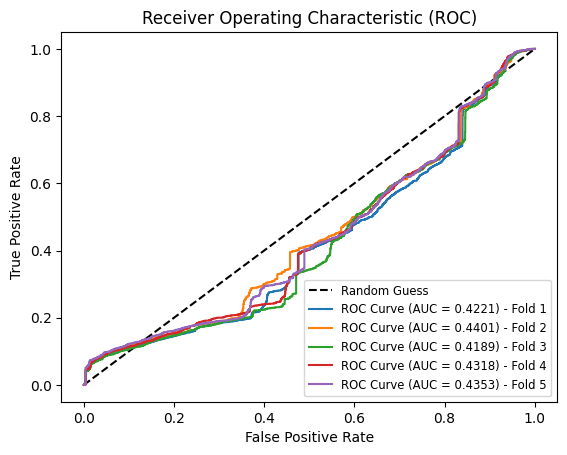

In [5]:
X_prior = df_prior.drop(['label', 'sha256'], axis=1)
y_prior = df_prior['label']
clf = LogisticRegression()
print_cv_clf(clf, X_prior, y_prior)

<u><font size=5>First Logistic Regression Model's Results</font></u><br>
It's clear that this model isn't very accurate. We recieved a validation AUC score of 42.96%, which by using it's complement turns to 57.04%. It means that this simple model pretty much completely guesses the classification of the file. 
Despite the low scoring there is a conclusion to be taken from this model:
The train set score is 42.81%, which its complement is 57.19%. When the scores on the train and validation sets are close it means that the bias-variance tradeoff is somewhat balanced, but we will not give these scores much importance since this is only a benchmark to see if our hard work on the pre-processing will pay off. 

<u><font size=6>Exploring the Data</font></u><br>
In this section we present the distributions of the features in the data. We will explore and try to understand key takeaways regarding the different features. It might assist us down the road to discover relations and mathematical transformations that we could implement on the data during the pre-processing.  

We will use 'log' to plot the distributions in order to normalize the values of the features, so that it will be easier to observe the plots and conclude regarding it. 

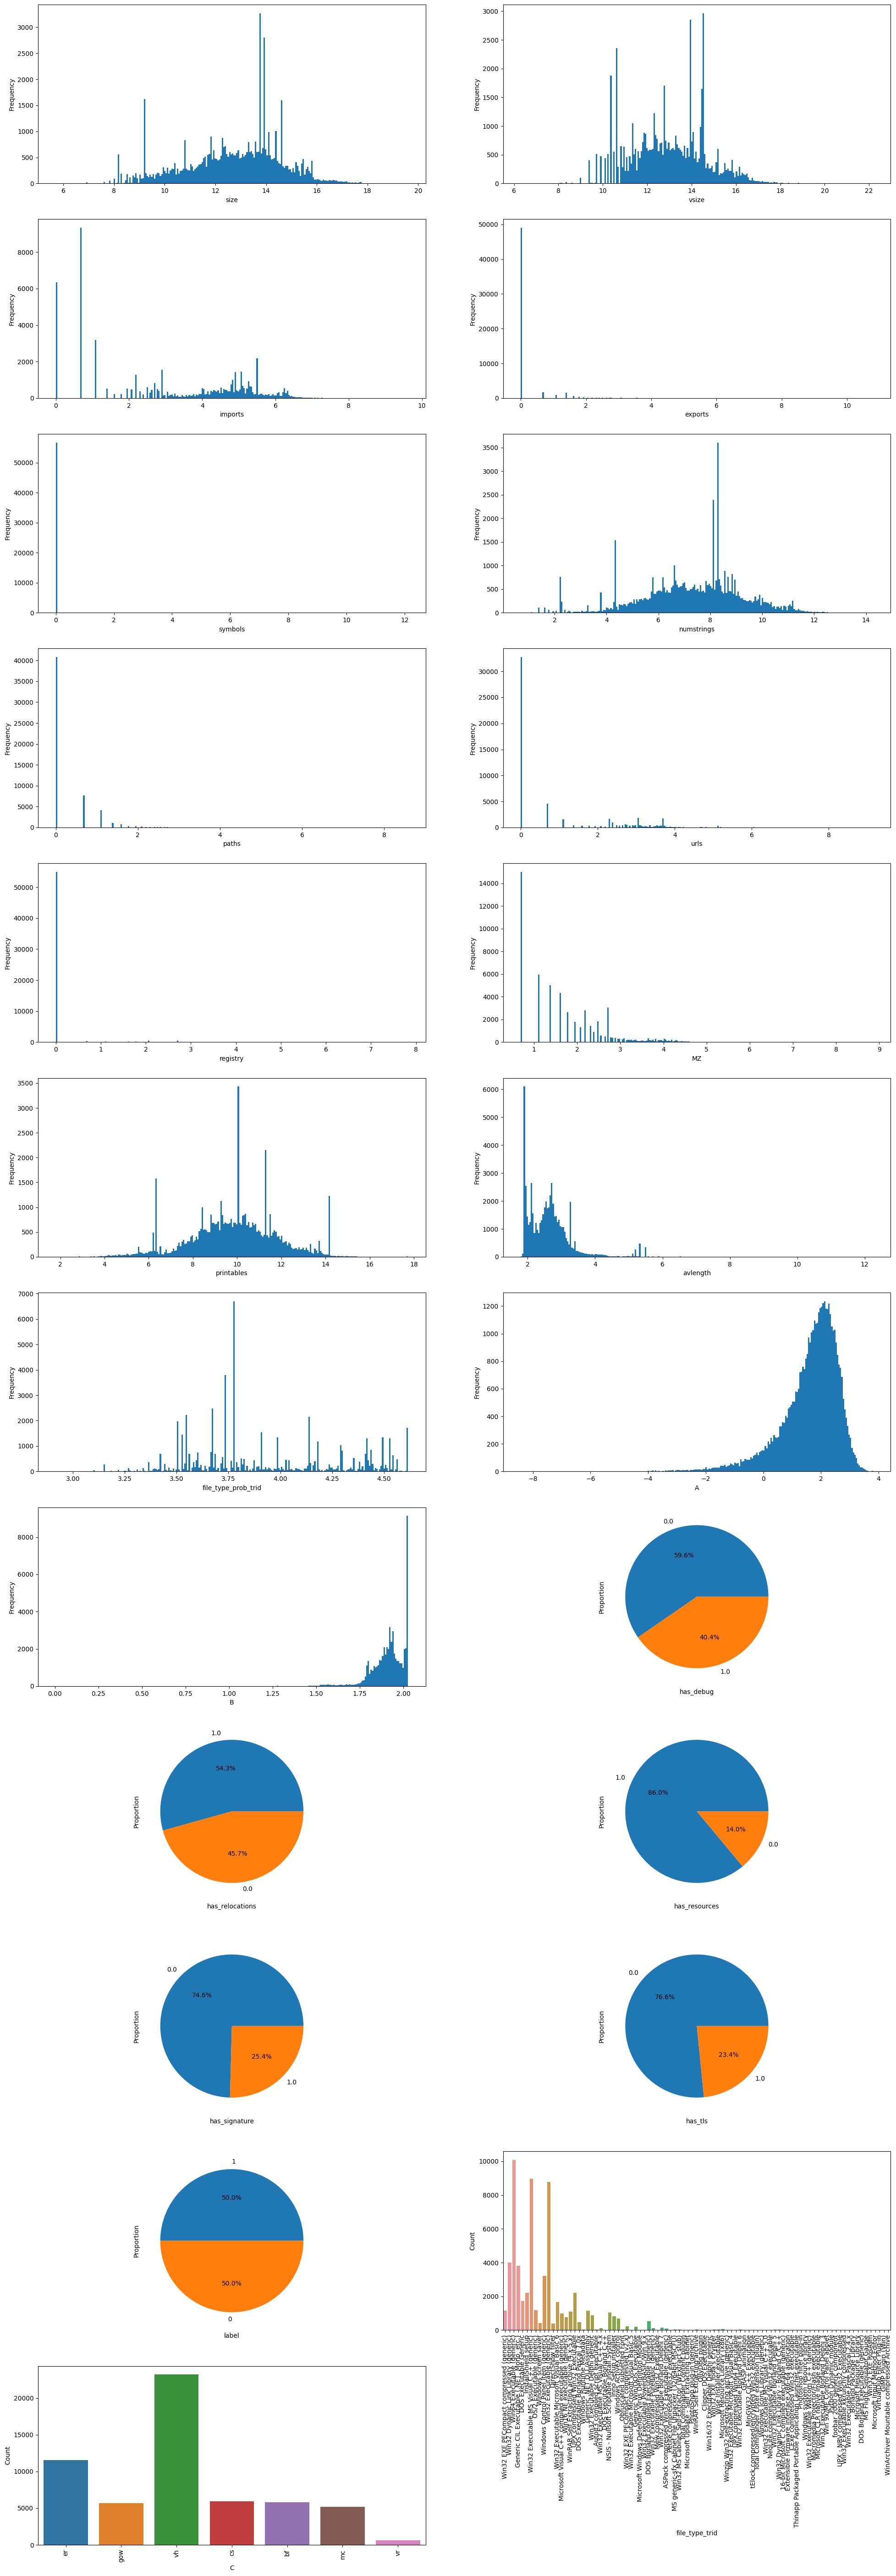

In [6]:
numeric_columns = []
binary_columns = []
categorical_columns = []

for column in dataset.columns[1:]:
    if dataset[column].nunique() == 2:
        binary_columns.append(column)
    elif dataset[column].dtype == 'object':
        categorical_columns.append(column)
    elif dataset[column].dtype in ['int64', 'float64']:
        numeric_columns.append(column)

num_plots = len(numeric_columns) + len(binary_columns) + len(categorical_columns)
num_rows = int(np.ceil(num_plots / 2))
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i, column in enumerate(numeric_columns + binary_columns + categorical_columns):
    ax = axes[i]
    
    if column in binary_columns:
        counts = dataset[column].value_counts()
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%')
        ax.set_xlabel(column)
        ax.set_ylabel('Proportion')
    elif column in categorical_columns:
        sns.countplot(x=column, data=dataset, ax=ax)
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=90) 
    elif column in numeric_columns:
        ax.hist(np.log1p(dataset[column]), bins=int(np.sqrt(len(dataset))))
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

# Remove excess empty subplots
if num_plots < len(axes):
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

# Adjust size of categorical plot
for ax in axes:
    if ax is not None and ax.get_ylabel() == 'Count':
        ax.figure.set_size_inches(12 * num_cols, 6 * num_rows)

plt.subplots_adjust(wspace=0.2)  # Adjust horizontal spacing between columns
plt.show()

Looking at the results we can see the most of the numerical features such as 'symbols', 'imports' and 'urls' don't have a specific distribution and that '0' is their most common value. Other numerical features such as 'printables', 'numstrings', and 'A' seem like they are Normally dstributed.
Regarding the binary features we have their proportions which, by looking at the perfect 50% split of the label column, mean that they probably don't correlate much to the classification process. 
Finally we can observe the most common values in the categorical features and the most common values in them. 

According to the information we gathered from these visualizations, '0' is a common value in many features and no feature has a distribution important enough to be taken into consideration relating data transformation.

<u><font size=5>Feature Correlation Heatmap</font></u><br>
We will use a correlation heatmap to find whether there are features in the data that are related to each other in classifying the samples to malware or not. 

The correlation between 'size' and 'numstrings':  0.8988105869260525
The correlation between 'size' and 'MZ': 0.7159017755375129
The correlation between 'MZ' and 'numstrings':  0.648994519741059
The correlation between 'printables' and 'avlength':  0.6438197985164879


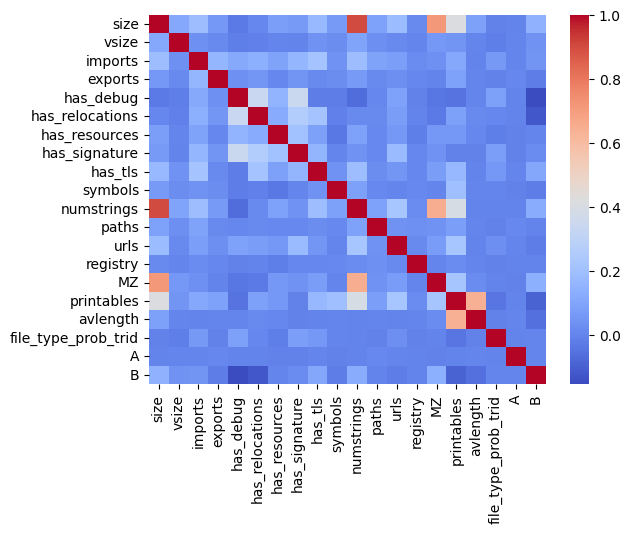

In [7]:
corr = dataset.iloc[:, :-1].corr() # the dataset without the labels
sns.heatmap(corr, annot=False, cmap='coolwarm')
print("The correlation between 'size' and 'numstrings': ", corr.loc["size", "numstrings"])
print("The correlation between 'size' and 'MZ':", corr.loc["size", "MZ"])
print("The correlation between 'MZ' and 'numstrings': ", corr.loc["MZ", "numstrings"])
print("The correlation between 'printables' and 'avlength': ", corr.loc["printables", "avlength"])

There are 4 distinctive pairs of correlated features in their original form (meaning without any transformations). 
The highly correlated feature pairs are 'size', 'numstrings' with a 89.88% correlation rate, and 'size', 'MZ' with a 71.59% correlation rate. 
The pairs 'MZ', 'numstrings' and 'printables', 'avlength' are not as highly correlated with about 64% correlation rate for both pairs. 

Down the road we will deal with the correlated features in the pre-processing stage. At the moment we haven't removed outliers, filled missing values or transformed any of the features so we will check the correlation map again after these actions will take place and only then act accordingly. 

<u><font size=5>Digging Further into the Data</font></u><br>
We will now present box, violin and scatter plots to further delve into the data. We will see the quarterly percentages and the amount of data in each percentage of the data. By doing this we prepare the ground for removing outliers.

Box plot - for understanding in general where are the outliers compared the rest of the samples.
Violin plot - for understanding the data density, and it gives us more information about the outliers and the distribution of the feature.
Scatter plot - gives us more specific details about the data distribution and a rough view of the outliers' values. 

From all of this info we can conclude how to deal with the outliers of each feature more wisely.

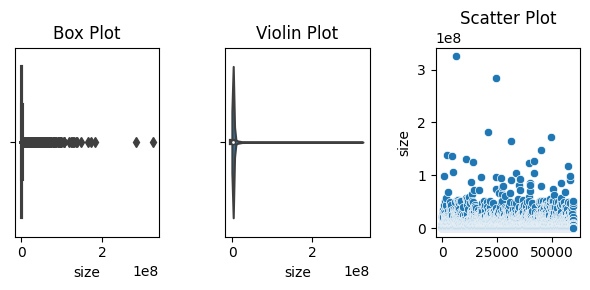

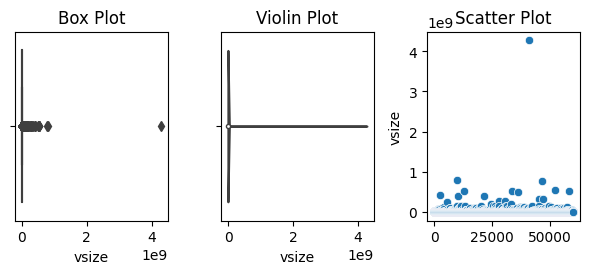

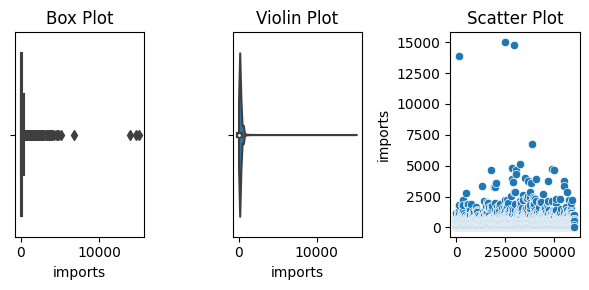

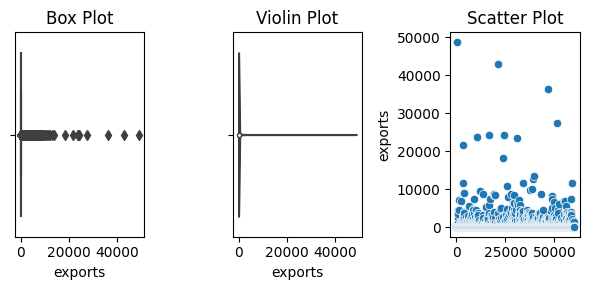

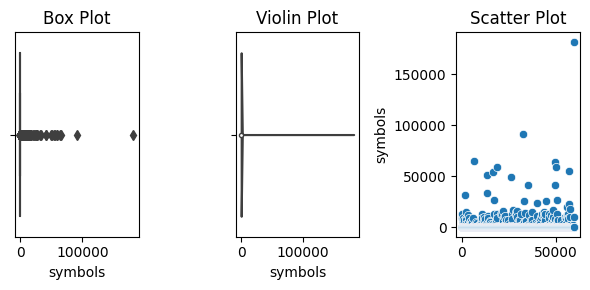

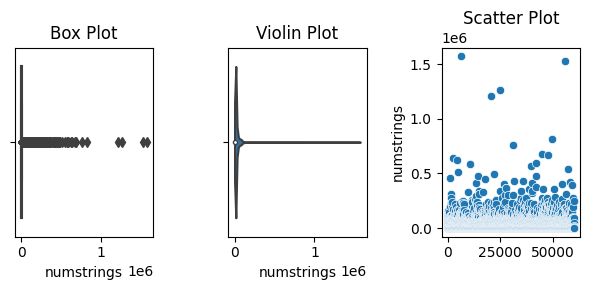

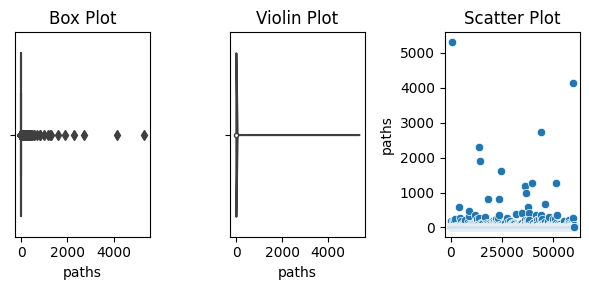

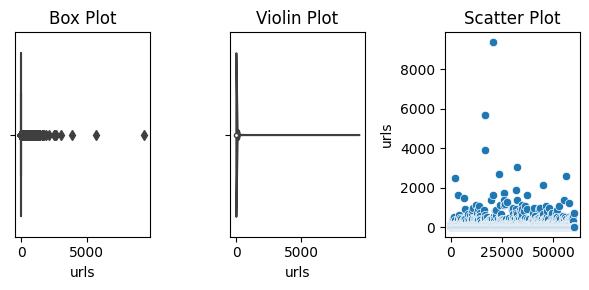

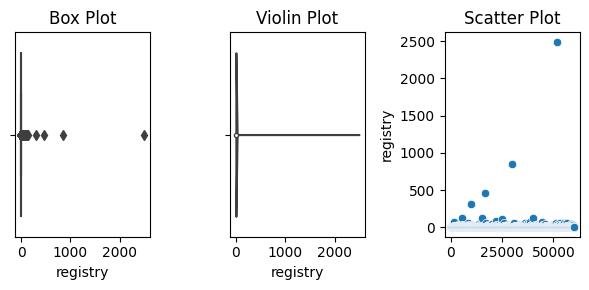

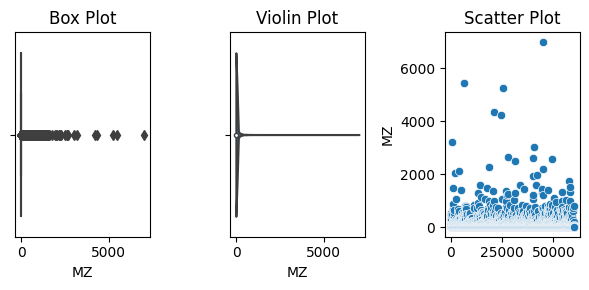

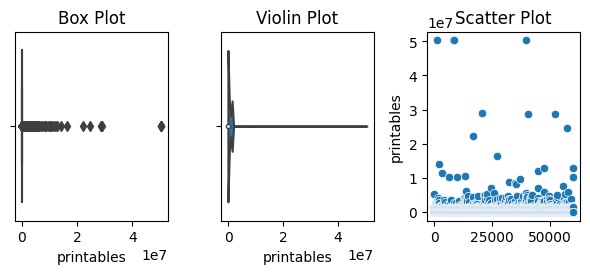

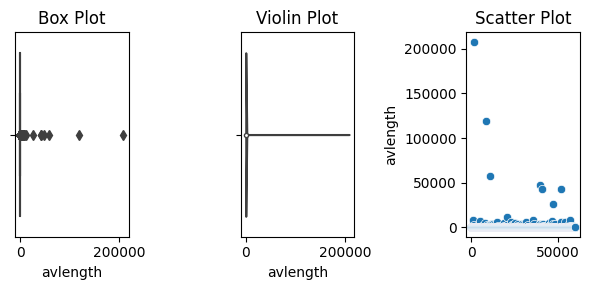

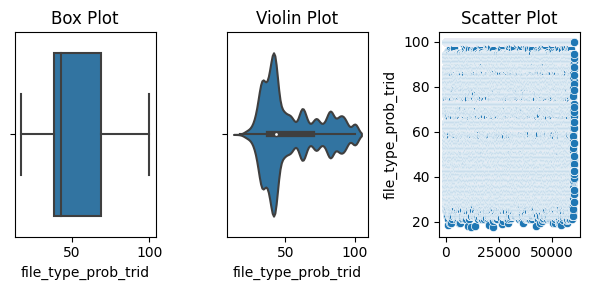

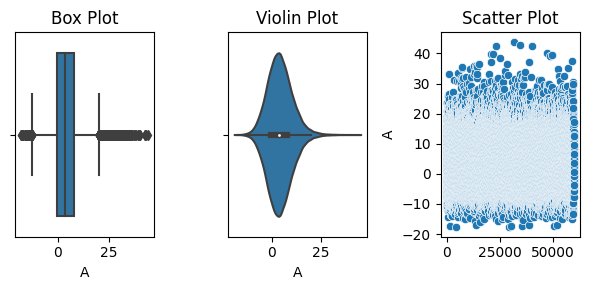

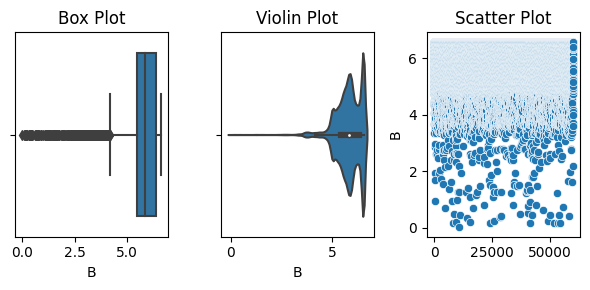

In [8]:
for column in dataset.columns[1:]:
    if dataset[column].nunique() == 2:
        continue
        
    elif dataset[column].dtype in ['int64', 'float64']: 
        plt.figure(figsize=(6, 3))
    
    # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(x=column, data=dataset)
        plt.title('Box Plot')
    
    # Violin plot
        plt.subplot(1, 3, 2)
        sns.violinplot(x=column, data=dataset)
        plt.title('Violin Plot')
    
    # Scatter plot with outliers
        plt.subplot(1, 3, 3)
        sns.scatterplot(x=dataset.index, y=column, data=dataset)
        plt.title('Scatter Plot')
        plt.tight_layout()
        plt.show()

<u><font size=6>Pre-Processing</font></u><br>
As we can see, some features' outliers spread differently from others, so we want to deal better in each case. For that we will discover the statistics in details:

<u>Unused Outlier Removal Method</u><br>
Below is a table showing statistical information about the features. For each feature we show the amount of values it has, median, mean, std, min and max values, and the value of each percentile in the top and bottom 10% in jumps of 2%. 
This data will give us a clue about the scales of each feature and the differences between the percentiles in each feature. 

In [9]:
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.0f}'.format

percentiles = [0.02, 0.04, 0.06, 0.08, 0.1, 0.90, 0.92, 0.94, 0.96, 0.98]
statistics = dataset.describe(percentiles=percentiles).round(2)
statistics_table = tabulate(statistics, headers='keys', tablefmt='pretty')
print(statistics_table)

+-------+-------------+--------------+---------+---------+-----------+-----------------+---------------+---------------+---------+----------+------------+---------+---------+----------+---------+------------+-----------+---------------------+---------+---------+---------+
|       |    size     |    vsize     | imports | exports | has_debug | has_relocations | has_resources | has_signature | has_tls | symbols  | numstrings |  paths  |  urls   | registry |   MZ    | printables | avlength  | file_type_prob_trid |    A    |    B    |  label  |
+-------+-------------+--------------+---------+---------+-----------+-----------------+---------------+---------------+---------+----------+------------+---------+---------+----------+---------+------------+-----------+---------------------+---------+---------+---------+
| count |   60000.0   |   58065.0    | 58261.0 | 57907.0 |  57073.0  |     56676.0     |    58039.0    |    58063.0    | 57102.0 | 57344.0  |  57282.0   | 56340.0 | 57651.0 | 57475.

The follwing table uses the statistics table and counts for each feature the number of values that is included in the given percentile. We will use this information to find the largest gaps in the values, and it will be our method of removing the outliers for each feature. 
In doing so we assume that each features' outliers are not the same, meaning we assume the worst case scenario since it implies removing the largest amount of data possible, and we will decide for each feature the percentile from which we will remove samples.

In [10]:

above_percentiles_count = []
below_percentiles_count = []


# Count outliers above the percentiles and below the thresholds

for column in statistics.columns:
    if column in statistics.columns:  # Check if column exists in the statistics DataFrame
        above_percentiles_count.append([(dataset[column] >= statistics[column][str(int(p*100))+'%']).sum() for p in percentiles[5:]]) #90% and up
        below_percentiles_count.append([(dataset[column] <= statistics[column][str(int(p*100))+'%']).sum() for p in percentiles[:5]]) #10% and down

above = pd.DataFrame(above_percentiles_count).T # lines in statistics: 10-14 including 14
below = pd.DataFrame(below_percentiles_count).T # lines in statistics: 4-8 including 8


stat_counts = pd.concat([statistics[4:9].copy(), statistics[10:15].copy()], axis=0)
stat_counts.iloc[0:5, :] = below.values
stat_counts.iloc[5:, :] = above.values
stat_counts = stat_counts.drop(feat_bin, axis=1) # Dropping the binary features 
stat_counts = stat_counts.drop(['label','file_type_prob_trid'] , axis=1) #Dropping the labels and file_type_prob_trid

pd.options.display.max_columns = None
pd.options.display.float_format = '{:.0f}'.format
stat_counts_table = tabulate(stat_counts, headers='keys', tablefmt='pretty')
print(stat_counts_table)


+-----+--------+--------+---------+---------+---------+------------+---------+---------+----------+---------+------------+----------+--------+--------+
|     |  size  | vsize  | imports | exports | symbols | numstrings |  paths  |  urls   | registry |   MZ    | printables | avlength |   A    |   B    |
+-----+--------+--------+---------+---------+---------+------------+---------+---------+----------+---------+------------+----------+--------+--------+
| 2%  | 1309.0 | 1233.0 | 6338.0  | 49034.0 | 56767.0 |   1375.0   | 40792.0 | 32732.0 | 54948.0  | 15008.0 |   1147.0   |  1107.0  | 1127.0 | 1129.0 |
| 4%  | 2461.0 | 2678.0 | 6338.0  | 49034.0 | 56767.0 |   2554.0   | 40792.0 | 32732.0 | 54948.0  | 15008.0 |   2317.0   |  1788.0  | 2249.0 | 2266.0 |
| 6%  | 3986.0 | 4562.0 | 6338.0  | 49034.0 | 56767.0 |   3437.0   | 40792.0 | 32732.0 | 54948.0  | 15008.0 |   4034.0   |  1788.0  | 3374.0 | 3407.0 |
| 8%  | 4845.0 | 5121.0 | 6338.0  | 49034.0 | 56767.0 |   4951.0   | 40792.0 | 32732.0 |

Before dealing with the outliers we want to check how many missing values are there for each feature. It is done mostly to have a sanity check after filling the missing samples with the appropriate values for each feature. 

In the following cell we also divide the features into different categories, according to the method we will use to fill their missing values. 

1. The first method is to fill the missing values with '0'. It works for the features in the 'to_zero' DataFrame since their most common value is indeed '0'. This way we will not interfere with the original proportions of their values. 
2. The second method is to fill the missing values with the median. It works for the features which are sensitive to extreme values and that way we will avoid influencing the values and their distribution. We use this method for the features in the 'to_median' DataFrame.
3. The third method is filling the mean value. The chosen features for this method do not have extreme outliers and therefore this is the best way to fill the missing values and keep the feature distribution as it was. 
4. The fourth method we used is for the categorical feature 'C'. We filled its missing values with the most common value. 
5. The fifth method we used will be explained before its implementation.

In [11]:
null_counts_by_column = dataset.isnull().sum(axis=0)
print(null_counts_by_column)
print('Sum of NAs: ', np.sum(null_counts_by_column))

to_zero = ['has_debug', 'has_resources', 'has_relocations', 'has_tls', 'has_signature', 'registry', 'symbols']
to_median = ['A', 'imports', 'exports', 'numstrings', 'avlength', 'MZ', 'paths','urls']
to_mean = ['printables', 'B']
counts_C = dataset['C'].value_counts()
print(f'\n{counts_C}')

sha256                    0
size                      0
vsize                  1935
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2656
numstrings             2718
paths                  3660
urls                   2349
registry               2525
MZ                     3089
printables             2739
avlength               2757
file_type_trid            0
file_type_prob_trid       0
A                      3704
B                      3751
C                      2051
label                     0
dtype: int64
Sum of NAs:  50813

vh     23226
er     11575
cs      5948
bf      5788
gow     5654
mc      5156
vr       602
Name: C, dtype: int64


<u><font size=5>Splitting the data to Train and Validation sets</font></u><br>
We did the split before doing any of the pre-processing so that the validation set could count as unknown data when using models. 


In [12]:
y = dataset['label']
X = dataset.iloc[:,:-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

'X_train', 'y_train' and 'X_val', 'y_val' will be used to choose the dimension reduction method. We will train on 'X_train', 'y_train' and treat 'X_val', 'X_val' as our test sets.
The DataFrame 'dataset' will be used to train our models and will be used in our cross-validation strategy. We do this because we don't want to lost 20% of the data that will stay in the validation set when doing the cross-validation. We will do the pre-processing on all three DataFrames, but we will use the statistics of the whole dataset to fill the missing values since we want to train on the whole dataset eventually.<br><br>
<u>Saving the dataset so we'll be able to use it to fill the missing values without losing the original dataset</u>

In [13]:
dataset_filling = dataset.copy()

<u><font size=5>Filling the missing values</font></u>

In [14]:
def fillna_champ(X ,dataset):
    X[to_zero] = X[to_zero].fillna(0)
    X[to_median] = X[to_median].fillna(dataset[to_median].median())
    X[to_mean] = X[to_mean].fillna(dataset[to_mean].mean())
    X['C'] = X['C'].fillna(dataset['C'].value_counts().idxmax())
    return X 

In [15]:
dataset = fillna_champ(dataset, dataset_filling)
X_train = fillna_champ(X_train, dataset_filling)
X_val = fillna_champ(X_val, dataset_filling)

Here is the explenation for the fifth missing values method. The feature 'vsize' has missing values but we didn't know how to easily fill them without damaging the data distribution. We believe that the 'size' and the 'vsize' of a file are related. In order to predict the virtual size of a file we wanted to use files with similar sizes. Moreover we noticed that 'size' does not have missing values, which is a big relief. To do that we used KNN with K being the square root of the amount of samples in the data. 

In [16]:
def knn_champ(X, dataset):
    # Extract the columns from the dataset that require imputation
    columns_to_impute = ['size', 'vsize']
    # Initialize a dictionary to store the imputers
    imputers = {}
    # Iterate over each column to impute
    for column in columns_to_impute:
        # Create a KNNImputer object for the current column
        imputer = KNNImputer(n_neighbors=5)
        # Fit the imputer on the corresponding column values in dataset
        imputer.fit(dataset[[column]])
        # Store the imputer in the dictionary
        imputers[column] = imputer
        # Impute the missing values in X_train using the fitted imputer
        X[column] = imputer.transform(X[[column]])

    return X

In [17]:
dataset = knn_champ(dataset, dataset_filling)
X_train = knn_champ(X_train, dataset_filling)
X_val = knn_champ(X_val, dataset_filling)

After filling all the missing values, we'll run a sanity check to make sure we actually filled all the missing values in all three DataFrames.

In [18]:
null_counts_by_column = X_train.isnull().sum(axis=0)
print(null_counts_by_column)

sha256                 0
size                   0
vsize                  0
imports                0
exports                0
has_debug              0
has_relocations        0
has_resources          0
has_signature          0
has_tls                0
symbols                0
numstrings             0
paths                  0
urls                   0
registry               0
MZ                     0
printables             0
avlength               0
file_type_trid         0
file_type_prob_trid    0
A                      0
B                      0
C                      0
dtype: int64


In [19]:
null_counts_by_column = X_val.isnull().sum(axis=0)
print(null_counts_by_column)

sha256                 0
size                   0
vsize                  0
imports                0
exports                0
has_debug              0
has_relocations        0
has_resources          0
has_signature          0
has_tls                0
symbols                0
numstrings             0
paths                  0
urls                   0
registry               0
MZ                     0
printables             0
avlength               0
file_type_trid         0
file_type_prob_trid    0
A                      0
B                      0
C                      0
dtype: int64


In [20]:
null_counts_by_column = dataset.isnull().sum(axis=0)
print(null_counts_by_column)

sha256                 0
size                   0
vsize                  0
imports                0
exports                0
has_debug              0
has_relocations        0
has_resources          0
has_signature          0
has_tls                0
symbols                0
numstrings             0
paths                  0
urls                   0
registry               0
MZ                     0
printables             0
avlength               0
file_type_trid         0
file_type_prob_trid    0
A                      0
B                      0
C                      0
label                  0
dtype: int64


After finishing with the missing values, we will use a heatmap again to see if our actions changed the correlation or if the fact we filled the missing values changed anything about the correlation of the features.

The correlation between 'size' and 'numstrings':  0.8805566498458198
The correlation between 'size' and 'MZ': 0.7017670761741172
The correlation between 'MZ' and 'numstrings':  0.623182615643954
The correlation between 'printables' and 'avlength':  0.5800571429141063


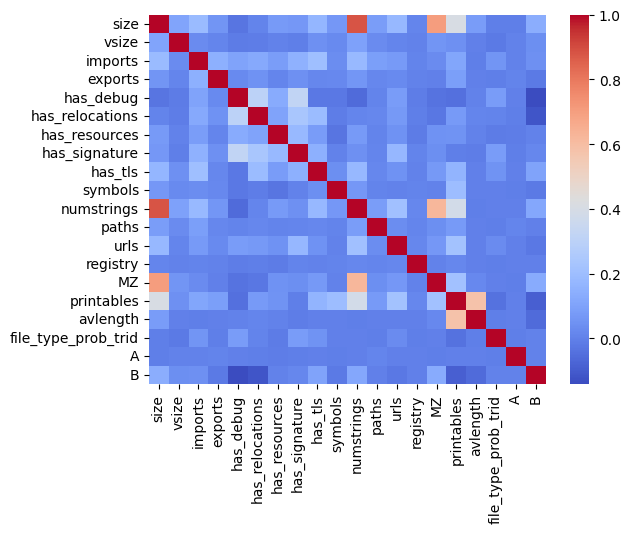

In [21]:
corr = dataset.iloc[:, :-1].corr() # the dataset without the labels
sns.heatmap(corr, annot=False, cmap='coolwarm')
print("The correlation between 'size' and 'numstrings': ", corr.loc["size", "numstrings"])
print("The correlation between 'size' and 'MZ':", corr.loc["size", "MZ"])
print("The correlation between 'MZ' and 'numstrings': ", corr.loc["MZ", "numstrings"])
print("The correlation between 'printables' and 'avlength': ", corr.loc["printables", "avlength"])

There was no real change in the correlation map, so our conclusions from the previous one are still intact and will be executed in the next few cells.

<u><font size=5>Adding, Removing and Transforming Features</font></u><br>
We used 'One Hot Encoding' to deal with the categorical features. This will bloat our feature count but we didn't want to use other encoding methods since we don't want to change the representation of the feature values (like in ordinal encoding for example) or to create a false implication of relationships between the feature values. 

In the next cell we will have a list of the encoded features so that we will be able to change the DataFrames to be ordered in the same way. 

In [2704]:
unique_file_type = 'file_type_trid_' + dataset[feat_cat[0]].unique()
unique_C = 'C_' + dataset[feat_cat[1]].unique()
unique_file_type = unique_file_type.tolist()
unique_C = unique_C.tolist()
global combined_list
combined_list = unique_file_type + unique_C
combined_list = list(map(str, combined_list))
print(combined_list)

KeyError: 'file_type_trid'

<u>The Encoding Function</u>

In [23]:
def encoder_champ(data):

    #one-hot encoding
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_cols = encoder.fit_transform(data[feat_cat])
    #Create a DataFrame from the encoded columns
    dummy_vars = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(feat_cat), index=data.index)
    #Drop the categorical columns
    data = data.drop(feat_cat, axis=1)
    #Add 'sha256' column as the first column
    dummy_vars.insert(0, 'sha256', data['sha256'])
    #Concatenate dummy variables and numeric columns
    new_data = pd.concat([dummy_vars, data.drop('sha256', axis=1)], axis=1)
    
    print(f"Number of features before encoding: {data.shape[1]}")
    print(f"Number of features after encoding: {new_data.shape[1]}\n")
    return new_data


Throughout the project we had many difficulties regarding the feature indexes of the different datasets due to the encoding and the dimension reduction. To make sure the label and the data will have the same indices, we will connect them and then seperate them again before the dimension reduction.

In [24]:
y_train_df = y_train.to_frame().rename(columns={y_train.name: 'label'})
merged_train = pd.merge(X_train, y_train_df, left_index=True, right_index=True)
y_val_df = y_val.to_frame().rename(columns={y_val.name: 'label'})
merged_val = pd.merge(X_val, y_val_df, left_index=True, right_index=True)


In [25]:
print('Encoding the Dataset:')
dataset = encoder_champ(dataset) 
print('Encoding the Train Set:')
merged_train = encoder_champ(merged_train) 
print('Encoding the Validation Set:')
merged_val = encoder_champ(merged_val)

Encoding the Dataset:
Number of features before encoding: 22
Number of features after encoding: 118

Encoding the Train Set:
Number of features before encoding: 22
Number of features after encoding: 117

Encoding the Validation Set:
Number of features before encoding: 22
Number of features after encoding: 96



<u><font size=5>Removing Outliers</font></u><br>
The encoder we used gave us a lot of new features. We decided we want to remove those that are full of '0' since they do not contribute to the data. We put a threshold of 0.0005% and we will remove all the features that have less than that percentage of values that are not '0'. We wanted to cause a minimal yet effective removal before reducing the dataset's dimensions.<br><br>
<u>The Manual Feature Removing Function</u>

In [26]:
def removing_irrelevant_encoding_champ(X):
    X_columns = set(X.columns[:-1])
    for column in combined_list:
        if column not in X_columns:
            X[column] = 0
        
    # Count the number of values equal to 1 in each column of new_d[combined_list]
    counts = X[combined_list].sum(axis=0)
    # Drop columns with counts less than 0.00005*len(X)
    columns_to_drop = counts[counts < 0.00005*len(X)].index #if the colums does not have sample with 1 that 0.00005% from the data the column is not relevant 
    X.drop(columns_to_drop, axis=1, inplace=True)
    print(f'The amount of features after the encoding and dropping irrelevant features: {X.shape[1]}')
    return X

In [27]:
dataset = removing_irrelevant_encoding_champ(dataset)
merged_train = removing_irrelevant_encoding_champ(merged_train)
merged_val = removing_irrelevant_encoding_champ(merged_val)



The amount of features after the encoding and dropping irrelevant features: 102
The amount of features after the encoding and dropping irrelevant features: 100
The amount of features after the encoding and dropping irrelevant features: 96


According to the results we got in the correlation map, we decided to remove the feature 'numstrings' due to its high correlation with 'size', and remove the feature 'file_type_prob_trid' because we think it doesn't give us any useful information.<br>
We then merged the features 'size', 'MZ'. We did that using the interaction between them.<br>
Moreover, as stated we believe there's a connection between 'size' and 'vsize' of a file. We created a new feature that represents the ratio between them. Intuitively, malware might try to take over space in a computer and demand a large amount of virtual space compared to its actual size.<br><br>
<u>The Feature Transformation Function:</u>

In [28]:
def transformation_champ(X):
    X['size_ratio'] = ((X['vsize'])) / (X['size'])
    X['size_MZ_interaction'] = X['size'] * X['MZ']

    X.drop('numstrings', axis = 1, inplace = True)
    X.drop('size', axis = 1, inplace = True)
    X.drop('vsize', axis = 1, inplace = True)
    X.drop('MZ', axis = 1, inplace = True)
    X.drop('file_type_prob_trid', axis = 1, inplace = True)
    if "label" in X.columns:
        label_column = X.pop('label')  # Remove the 'label' column from the DataFrame
        X['label'] = label_column  # Add the 'label' column back to the DataFrame at the end
    return X

In [29]:
dataset = transformation_champ(dataset)
print(f'The amount of features after the transformation in dataset: {dataset.iloc[:,:-1].shape[1]}')

merged_train = transformation_champ(merged_train)
print(f'\nThe amount of features after the transformation in merged_train: {merged_train.iloc[:,:-1].shape[1]}')

merged_val = transformation_champ(merged_val)
print(f'\nThe amount of features after the transformation in merged_val: {merged_val.iloc[:,:-1].shape[1]}')

The amount of features after the transformation in dataset: 98

The amount of features after the transformation in merged_train: 96

The amount of features after the transformation in merged_val: 92


<u><font size=5>Normalization of the Data</font></u><br>
We used Min-Max normalization on the numerical features. It reduces the impace of extreme values by forcing all the data to be between 0 and 1. We did the normalization now because it will assist us in removing the outliers from the DataFrames. We want the features to be in the same scale in our outlier removal. 

In [30]:
feat_numeric = ['size_ratio', 'imports', 'exports', 'paths', 'urls', 'printables', 'avlength', 'A', 'B', 'size_MZ_interaction', 'symbols', 'registry']

scaler = MinMaxScaler()
numeric_train_set_normalized = scaler.fit_transform(merged_train[feat_numeric])
numeric_train_set_normalized = pd.DataFrame(numeric_train_set_normalized, columns=feat_numeric)

numeric_val_set_normalized = scaler.fit_transform(merged_val[feat_numeric])
numeric_val_set_normalized = pd.DataFrame(numeric_val_set_normalized, columns=feat_numeric)
# The numeric_Val_set_normalized is at the moment type: Any, we decided no to turn it into a df

numeric_dataset_normalized = scaler.fit_transform(dataset[feat_numeric])
numeric_dataset_normalized = pd.DataFrame(numeric_dataset_normalized, columns=feat_numeric)

In the next cell we updated the Train and Validation data with the normalized values of their respective data.

In [31]:
merged_train = pd.DataFrame(merged_train).copy()
merged_train = merged_train.reset_index(drop=True)
merged_train[feat_numeric] = numeric_train_set_normalized[feat_numeric]

merged_val = pd.DataFrame(merged_val).copy()
merged_val = merged_val.reset_index(drop=True)
merged_val[feat_numeric] = numeric_val_set_normalized[feat_numeric]

dataset = pd.DataFrame(dataset).copy()
dataset = dataset.reset_index(drop=True)
dataset[feat_numeric] = numeric_dataset_normalized[feat_numeric]


<u><font size=5>Outlier Removal</font></u><br>
We tried to remvoe the outliers in a smart way without removing a big chunk of the data. We decided to use Mahalanobis distance of each sample from the mean the feature and remove the 5% that are the farthest. Mahalanobis distance is sensitive to the shape of the data, that's why we normalized it beforehand. The advantages of using this distance are that it provides a quantitive measure of how extreme a sample is by a threshold, and it accounts for the correlation between the features which is important in a multi-dimensional dataset.<br><br>
<u>The Outlier Removal Function:</u>

In [32]:
def remove_outliers_champ(X):
    #Compute the covariance matrix
    cov_matrix = np.cov(X.iloc[:,1:-1].T) #not including sha256 & label
    #Compute the inverse covariance matrix
    inverse_cov_matrix = np.linalg.inv(cov_matrix)
    #Calculate the Mahalanobis distance for each sample
    mean = np.mean(X.iloc[:,1:-1], axis=0)
    centered_data = X.iloc[:,1:-1] - mean
    mahalanobis_distances = np.sqrt(np.einsum('ij, ij -> i', np.dot(centered_data, inverse_cov_matrix), centered_data))

    #Detect outliers
    threshold = np.percentile(mahalanobis_distances, 95)  
    outlier_indices = np.where(mahalanobis_distances > threshold)[0]
    print("Detected outliers:", len(outlier_indices))

    #Remove outliers from the data and labels
    filtered_data = X.drop(outlier_indices)
    
    return filtered_data

In [33]:
print("Outliers removed from dataset:")
dataset = remove_outliers_champ(dataset)
print("Outliers removed from merged_train:")
merged_train = remove_outliers_champ(merged_train)

Outliers removed from dataset:
Detected outliers: 3000
Outliers removed from merged_train:
Detected outliers: 2400


<u>Seperating the labels before dimension reduction</u>

In [34]:
X_dataset = dataset
y_dataset = dataset['label']
X_dataset.drop('label', axis=1, inplace=True)

X_train = merged_train
y_train = merged_train['label']
X_train.drop('label', axis=1, inplace=True)

X_val = merged_val
y_val = merged_val['label']
X_val.drop('label', axis=1, inplace=True)

<u><font size=5>Dimension Reducing</font></u><br>
We decided to run both PCA and Backward-Selection and then see which method will give us the better results.
In this part -and this part only - we will use the X_train, y_train, X_val, y_val to choose the best features to fit with.
Afterwards when fitting the models, we will apply the features that were chosen on the full dataset because each model has a 5-fold cross-validation.

<u>PCA Implementation</u><br>
We run a PCA algorithm that keeps 99% of the data variance.

In [35]:
pca = PCA(0.99)
pca.fit(X_train.iloc[:, 1:]) #X_train without the samples' IDs
train_components = pca.components_
print(f'number of components which preserve at least 99% of the variance: {len(train_components)}')

number of components which preserve at least 99% of the variance: 31


<u>Backward-Selection Implementation</u><br>
We run a Backward-Selection algorithm, and then displayed the Mallow's CP score graph to evaluate the best amount of features chosen compared to all the other options.<br><br>
<u>Backward-Selection Functions:</u>

In [36]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    rss = np.sum((y-lr_model.predict(X))**2)
    return rss/(X.shape[0]-X.shape[1]-1)

def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    # train and predict using selected features
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    mse = mean_squared_error(y, lr_model.predict(X))

    # calculate cp
    n = X.shape[0]
    d = X.shape[1]
    cp = mse + sigma_hat_squared*2*((d+1)/n)
    return cp


def remove_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict:
    best_score = np.inf
    for i in range(len(current_features)):
    # remove feature
        potential_feature_lst = current_features.copy()
        potential_feature_lst.pop(i)
        potential_feature_arr = X[:,potential_feature_lst]
        #get mallows cp score
        model_score = get_mallows_cp_score(potential_feature_arr, y, sigma_hat_squared)
        # compare to best score
        if model_score < best_score:
            best_score = model_score
            best_features_lst = potential_feature_lst.copy()
            
    return {'features':sorted(best_features_lst),'score':best_score}

def backward_selection(X: np.array, y: np.array) -> List[int]:
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)
    # set initial features to all features
    current_features = list(range(X.shape[1]))
    models_lst = []
    #perform backward selection
    while len(current_features) > 1:
        # remove feature
        model = remove_feature(X, y, current_features, sigma_hat_squared)
        #update
        current_features = model['features']
        models_lst.append(model)
    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(list(reversed(range(1, len(scores_lst)+1))), scores_lst)
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)



<u>Implementing the Backward-Selection and showing Mallow's CP Score</u>

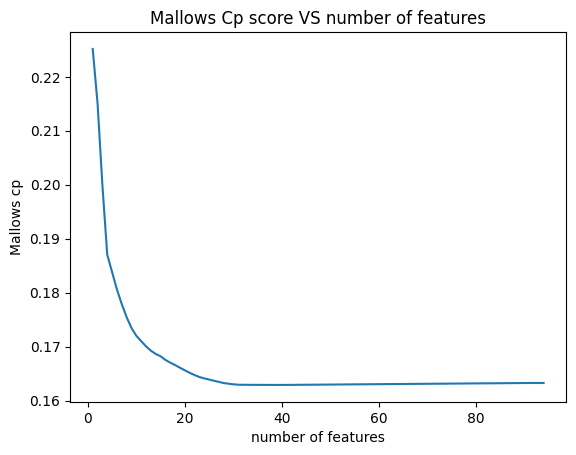

Number of selected features by backward selection: 39


In [37]:
res = backward_selection(np.array(X_train.iloc[:, 1:]),np.array(y_train))
chosen_column_names = list(X_train.columns[1:][res]) #the columns names
print(f'Number of selected features by backward selection: {len(res)}')

<u>Changing the dimensions of the train and validation sets to be the same, so we will be able to apply the featuree selection algorithem</u>

In [38]:
X_val_fix = X_val.copy()
X_train_columns_fix = set(X_train.iloc[:, 1:].columns)
X_val_columns_fix = set(X_val_fix.columns)
# Find the missing columns in X_val
missing_columns = X_train_columns_fix - X_val_columns_fix
# Add the missing columns to test_final and set their values to 0
for column in missing_columns:
    X_val_fix[column] = 0
# Reorder the columns in test_final to match the order of X_train
X_val_pca = X_val_fix[X_train.iloc[:, 1:].columns]
X_val_backward = X_val_fix[X_train.iloc[:, 1:].columns]


<u>Comparing the Methods</u><br>
We compared the methods like we did in our homework, using the MSE of the train and validation sets for each method.

In [39]:
# calculate the test MSE for each reduced dataset
x_backward_reduced_train = np.array(X_train.iloc[:, 1:])[:,res] #without sha256
x_backward_reduced_val = np.array(X_val_backward)[:,res]

# get components based on train set:
x_pca_train = np.dot(np.array(X_train.iloc[:, 1:]), train_components.T)
x_pca_val = np.dot(np.array(X_val_pca), train_components.T)



In [40]:
reg = LinearRegression()
reg_pca = LinearRegression()

reg.fit(x_backward_reduced_train, y_train)
reg_pca.fit(x_pca_train, y_train)

val_mse_backward = mean_squared_error(y_val,reg.predict(x_backward_reduced_val))
val_mse_pca = mean_squared_error(y_val,reg_pca.predict(x_pca_val))
train_mse_backward =  mean_squared_error(y_train,reg.predict(x_backward_reduced_train))
train_mse_pca = mean_squared_error(y_train,reg_pca.predict(x_pca_train))

print(f'MSE train - PCA: {round(train_mse_pca,4)}')
print(f'MSE val - PCA: {round(val_mse_pca,4)}')
print(f'MSE train - BACKWARD: {round(train_mse_backward,4)}')
print(f'MSE val - BACKWARD: {round(val_mse_backward,4)}')

MSE train - PCA: 0.1795
MSE val - PCA: 0.1818
MSE train - BACKWARD: 0.1626
MSE val - BACKWARD: 0.605


In [41]:
feature_names = X_train.columns[1:]  # Exclude the 'sha256' column
num_components = train_components.shape[0]  # Number of PCA components
# Get the feature names corresponding to the PCA components
pca_feature_names = [f'PC{i+1}' for i in range(num_components)]
# Map the original feature names to the PCA feature names
feature_names_pca = [feature_names[i] if i < len(feature_names) else pca_feature_names[i-len(feature_names)] for i in range(num_components)]
# Save the feature names from PCA in a list
feature_names_list = list(feature_names_pca)
# Print the feature names from PCA
print("Feature selected after PCA:")
for feature_name in feature_names_list:
    print(feature_name)


Feature selected after PCA:
file_type_trid_16-bit Microsoft C compiled executable (generic)
file_type_trid_ASPack compressed Win32 Executable (generic)
file_type_trid_AutoIt3 compiled script executable
file_type_trid_Borland Package Library
file_type_trid_CExe compressed Win32 executable
file_type_trid_Clipper DOS Executable
file_type_trid_DOS Borland Executable (generic)
file_type_trid_DOS Borland compiled Executable (generic)
file_type_trid_DOS Executable Borland C++
file_type_trid_DOS Executable Borland Pascal 7.0x
file_type_trid_DOS Executable Generic
file_type_trid_DirectShow filter
file_type_trid_GRASP animation
file_type_trid_Generic .NET DLL/Assembly
file_type_trid_Generic CIL Executable (.NET, Mono, etc.)
file_type_trid_Generic Win/DOS Executable
file_type_trid_Inno Setup installer
file_type_trid_InstallShield setup
file_type_trid_MS generic-sfx Cabinet File Unpacker (32/64bit MSCFU)
file_type_trid_Macromedia Projector/Flash executable
file_type_trid_Mew compressed Win32 Execu

In [42]:
print("Feature selected after BACKWARD:")
for feature in chosen_column_names:
    print(feature)

Feature selected after BACKWARD:
file_type_trid_DOS Borland compiled Executable (generic)
file_type_trid_DOS Executable Borland Pascal 7.0x
file_type_trid_DOS Executable Generic
file_type_trid_Generic .NET DLL/Assembly
file_type_trid_Generic CIL Executable (.NET, Mono, etc.)
file_type_trid_Inno Setup installer
file_type_trid_InstallShield setup
file_type_trid_NSIS - Nullsoft Scriptable Install System
file_type_trid_OS/2 Executable (generic)
file_type_trid_UPX compressed Win32 Executable
file_type_trid_Win16 NE executable (generic)
file_type_trid_Win32 Dynamic Link Library (generic)
file_type_trid_Win32 EXE PECompact compressed (generic)
file_type_trid_Win32 Executable Delphi generic
file_type_trid_Win32 Executable MS Visual C++ (generic)
file_type_trid_Win32 Executable Microsoft Visual Basic 6
file_type_trid_Win64 Executable (generic)
file_type_trid_WinRAR Self Extracting archive (4.x-5.x)
file_type_trid_Windows ActiveX control
file_type_trid_Windows Control Panel Item (generic)
C_bf
C

We discovered that the Validation MSE results are worse in backward selection than the PCA.<br> BUT! PCA chose only catagorial features and it's not considering the labels themselves when calculating the components. In Backward-Selection there are different types of features, features which we assume have more impact on the final prediction, and the model considers in advance the labels.<br> Therefore we chose to continue with the Backward-Selection.<br><br>

<u>Applying the Feature Selection on the Full Data for the Models</u><br>
From this part we will use only the 'dataset' for the 5-fold cross-validate.

In [43]:
columns_to_delete = set(X_dataset.columns) - set(X_train.columns)
X_dataset.drop(columns=columns_to_delete, inplace=True)
X_dataset = X_dataset[X_train.columns]
X_dataset = np.array(X_dataset.iloc[:, 1:])[:,res] #without sha256

<u><font size=5>Implementing the Pre-Processing on the Test Set</font></u><br>
<u>Checking if there are missing values in the Test set</u>

In [44]:
test = pd.read_csv('test.csv')
null_counts_by_column = test.isnull().sum(axis=0) # Checking that there aren't any rows with empty cells 
print(null_counts_by_column)

sha256                    0
size                      0
vsize                   572
imports                1274
exports                2814
has_debug              1614
has_relocations         995
has_resources           628
has_signature           555
has_tls                 886
symbols                 822
numstrings              825
paths                  1150
urls                    755
registry                745
MZ                      886
printables              842
avlength                793
file_type_trid            0
file_type_prob_trid       0
A                      1173
B                      1138
C                       593
dtype: int64


<u>Filling the Missing Values of the Test Set Using the Full Dataset Values</u>

In [45]:
test = fillna_champ(test, dataset_filling)
test = knn_champ(test, dataset_filling)
null_counts_by_column = test.isnull().sum(axis=0)
print(null_counts_by_column)

sha256                 0
size                   0
vsize                  0
imports                0
exports                0
has_debug              0
has_relocations        0
has_resources          0
has_signature          0
has_tls                0
symbols                0
numstrings             0
paths                  0
urls                   0
registry               0
MZ                     0
printables             0
avlength               0
file_type_trid         0
file_type_prob_trid    0
A                      0
B                      0
C                      0
dtype: int64


<u>One Hot Encoding the Test Data</u>

In [46]:
test = encoder_champ(test)

Number of features before encoding: 21
Number of features after encoding: 102



<u>Adding and Removing Features</u><br> We manually dropped features from the test data according to the results we had when we added and removed features from the Train data. We discovered there are less features after the encoding and needed to see which features were missing. 

In [47]:
test = removing_irrelevant_encoding_champ(test)
test = transformation_champ(test)
print(f'The amount of features after the encoding and transformation: {test.shape[1]}') #with shat256

The amount of features after the encoding and dropping irrelevant features: 102
The amount of features after the encoding and transformation: 99


We found out there are less values in the categorical feautres and therefore the encoding created less features. 

In [48]:
data_feat_cat_count = dataset.columns.nunique()
test_feat_cat_count = test.columns.nunique()
print(f'The difference between the amount of categorical values in the train file and the test file = {data_feat_cat_count - test_feat_cat_count}')
# That's why it makes sense that the test set has less features than the train set - due to the encoding.

The difference between the amount of categorical values in the train file and the test file = -3


<u>Normalizing the Test Data</u>

In [49]:
numeric_test_normalized = scaler.fit_transform(test[feat_numeric])
numeric_test_normalized = pd.DataFrame(numeric_test_normalized, columns=feat_numeric)
test = pd.DataFrame(test).copy()
test = test.reset_index(drop=True)
test[feat_numeric] = numeric_train_set_normalized[feat_numeric]
test_file_names = test['sha256'] #save the id column

<u>Applying Backward-Selection on the Test</u>

In [50]:
X_test_fix = test.copy()
X_dataset_columns_fix = set(chosen_column_names)
X_test_columns_fix = set(X_test_fix.columns)
# Find the missing columns in X_val
missing_columns = X_dataset_columns_fix - X_test_columns_fix 
for column in missing_columns:
    X_test_fix[column] = 0
# Reorder the columns in test_final to match the order of X_train
X_test_fix = X_test_fix[chosen_column_names]
test = np.array(X_test_fix) #without sha256


<u><font size=6>Models</font></u><br>
Now with our data ready, we can run our models.<br>
The mean ROC-AUC scores that will be obtained during k-fold cross-validation will provide insights into the bias-variance trade-off for each model. Higher scores on the train set suggest lower bias, while similar scores on both the train and validation sets indicate a good balance between bias and variance.<br> A significant difference between the train and validation scores may suggest overfitting or model complexity. The mean ROC-AUC scores will help evaluate the models' performance and their bias-variance characteristics.<br><br>
We used Grid_SearchCV on the models we wanted to test serveral options for their hyper-parameters, but due to runtime we commented out the Grid_SearchCV code and used its results from previous runs. The results are implemented into the model implementation and we will refer to the hyper-parameters we chose to change in each model explenation and in the final report.<br><br>
<u><font size=5>Logistic Regression</font></u>

Validation Mean AUCs Score: 0.8371148698923576
Train Mean AUCs Score: 0.8393419811072699


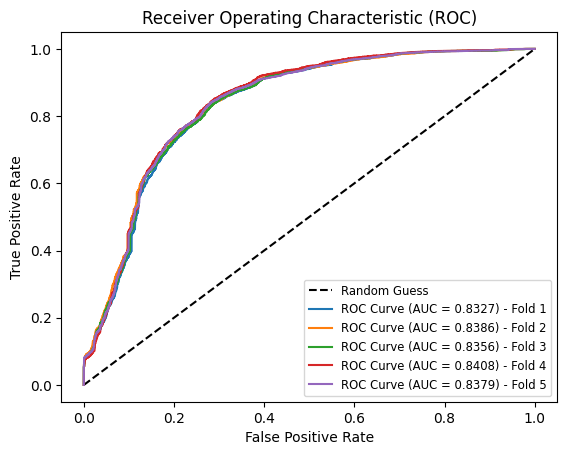

In [51]:
clf = LogisticRegression(max_iter=100, solver='newton-cholesky')
print_cv_clf(clf, X_dataset, y_dataset)

<u><font size=4>Model Results</font></u><br>
It's clear that the pre-processing contributed to the predictions. The prediction result for the validation set is 83.71% which is a great improvement from the previous result. The prediction result for the train set is 83.93%.<br> The model doesn't seem to have the lowest bias but it it's indeed low, due to the high train and validation scores. It also has a good bias-variance balance and a good generalization due to the scores being close.<br>

<u><font size=5>Naive Bayes</font></u>

Validation Mean AUCs Score: 0.7951984602868831
Train Mean AUCs Score: 0.7981420276728926


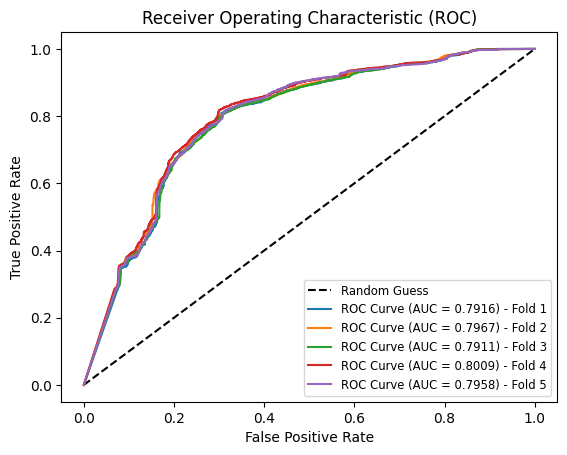

In [52]:
clf = GaussianNB()
print_cv_clf(clf, X_dataset, y_dataset)

The Naive Bayes is a simpler model than Logistic Regression, therefore the lower results do not surprise us, as we don't have any prior information about the computer virus field. The prediction result for the validation set is 79.51% and for the train set the prediction is 79.81%.<br> The bias seems to be higher than the in the Logistic Regression model, but it's still somewhat low due to the low scores. The variance is low because the gap between the scores is low and the generalization seems to be good because of the same reason. All in all it's not the worst model but it sure isn't a good one compared to the one we did and, according to our expectations, to those we will do.<br>
We expect the following models, which are more complicated, to give us more accurate results. 

<u><font size=5>Multilayer Perceptron</font></u>

Validation Mean AUCs Score: 0.9236383419148761
Train Mean AUCs Score: 0.9379088788245948


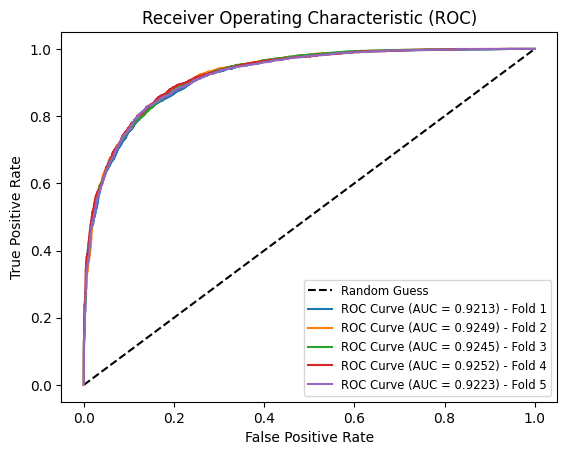

In [53]:
"""
clf = MLPClassifier(alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, epsilon=1e-08, max_iter=200,
              learning_rate_init=0.001, n_iter_no_change=10,
              random_state=123, solver='adam', learning_rate = 'constant')

params = {'activation': ['relu','tanh'],
          'hidden_layer_sizes': [(100,), (50,100,),]
         }

mlp_classif_grid = GridSearchCV(clf, param_grid=params, cv=5, scoring='roc_auc',n_jobs=2)
"""

clf = MLPClassifier(alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, epsilon=1e-08, max_iter=200,
              learning_rate_init=0.001, n_iter_no_change=10,
              random_state=123, solver='adam', learning_rate = 'constant',
              activation='relu', hidden_layer_sizes=(50, 100))
print_cv_clf(clf, X_dataset, y_dataset)


As expected the results for a more complicated model are better. We received a our highest score so far for the prediction of the validation set which is 92.36%, and the results for the predictions of the train set is 93.79%.<br>
The model has a low bias because the scores are high and similar. It also has a low variance and a good generalization due to the low gap.<br><br> The hyper-parameters we gave the GridSearchCV seem to be good choices. we decided to give the model a low amount of options due to runtime, but we wanted to have a comparison between what we think are two of the more, if not most, important hyper-parameters of this model which are the activation method and the hidden layer shapes. 

In [54]:
#print(f'Best Hyper-parameters for MLP model:\n{mlp_classif_grid.best_params_}')

<u><font size=5>ADABoost</font></u>

Validation Mean AUCs Score: 0.9595804445005267
Train Mean AUCs Score: 0.9817747176614537


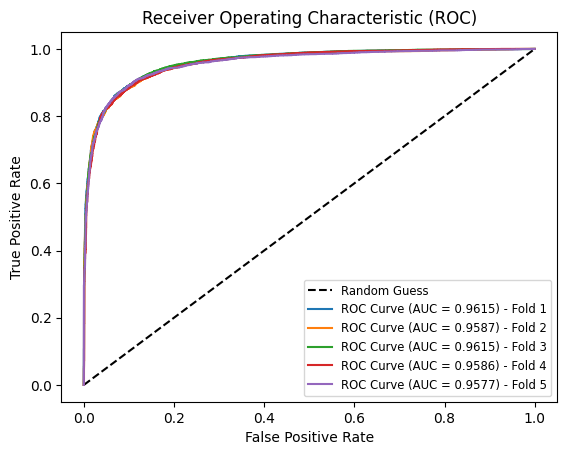

In [55]:
"""
clf = AdaBoostClassifier()

params = {
    'n_estimators': [50, 200],
    'learning_rate': [0.1, 0.5],
    'base_estimator': [DecisionTreeClassifier(max_depth=2), 
                       DecisionTreeClassifier(max_depth=3), 
                       DecisionTreeClassifier(max_depth=5)]
}

ada_classif_grid = GridSearchCV(clf, param_grid=params, cv=5, scoring='roc_auc',n_jobs=2)
"""
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), learning_rate=0.1, n_estimators= 200)
print_cv_clf(clf, X_dataset, y_dataset)

This model knocked it out the park with the highest score in this project. We received a score of 95.95% for the mean prediction on the validation set and a score of 98.17% for the mean prediction on the train set.<br> Both the bias and variance seems to be low because the scores are quite similiar. and the generalization seems to be good on this model.<br>
In this model we also chose a low amount of hyper-parameters for the GridSearchCV but, again, we wanted to try several options for the hyper-parameters we deemed most important: n_estimators, learning_rate and the max_depth.<br><br>
This is the model that we chose to predict the Test's probabilities of being malware.

In [56]:
#print(f'Best Hyper-parameters for Ada Boost model:\n{ada_classif_grid.best_params_}')

<u><font size=5>Voting Classifier</font></u><br>
This model is a model we didn't learn about in class. This model is an 'ensemble' type model which takes different models with different hyper-parameters, and gives the models different weights according to who we want to be more important between the bunch. Our plan of action is to give this model our best models, which are the Logistic Regression, Multi-Layer Perceptron, and ADABoost, and to give each model the hyper-parameters GridSearchCV found to be the best ones out of those we gave it to experiment with.<br>
We gave the Logistic Regression the lowest rating in all options and we gave ADABoost the most weight. Each option has a different proportion in which the models affect the Voting Classifier, but they all follow the same guidelines.<br>
We expect this model to be the best of all worlds in this project.

Validation Mean AUCs Score: 0.9370884833712723
Train Mean AUCs Score: 0.9470579706504167


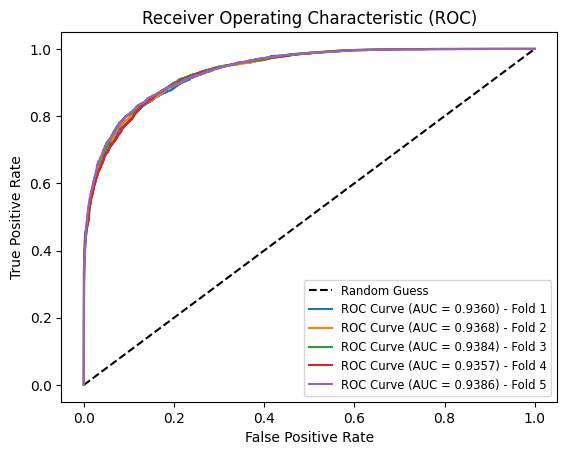

In [57]:
# 1) Logistic Regression = lr
lr = LogisticRegression(max_iter=100, solver='newton-cholesky')
# 2) AdaBoost = ada
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=200)
# 3) MLPClassifier = mlp
mlp = MLPClassifier(activation='relu', hidden_layer_sizes= (50, 100))
"""
clf = VotingClassifier(estimators=[('lr',lr),('ada',ada),('mlp',mlp)], voting='soft')

params = {
    'weights': [(.1, .6, .3), (.1, .7, .2), (.05, .8, .15)]
}
vot_classif_grid = GridSearchCV(clf, param_grid=params, cv=5, scoring='roc_auc',n_jobs=2)

print_cv_clf(vot_classif_grid, X_dataset, y_dataset)
"""
clf = VotingClassifier(estimators=[('lr',lr),('ada',ada),('mlp',mlp)], voting='soft', weights=(0.05, 0.8, 0.15))
print_cv_clf(clf, X_dataset, y_dataset)


The results of this model are, to our surprise, not the highest we have in this project. We received a mean prediction score of 93.71% on the Validation set and a score of 94.7% on the Train set.<br> The bias is low on this model due to both scores being high. The variance is low and the generalization is good because the gap between the scores is low. 

In [58]:
#print(f'Best Hyper-parameters for Voting model:\n{vot_classif_grid.best_params_}')

<u><font size=5>Confusion Matrix - AdaBoost Classifier</font></u><br>
This is the confusion matrix for our best scoring model - the AdaBoost Classifier. We chose to show the matrix of the last fold only, it will be a good representation of the accuracy of the model.<br> We received an Accuracy score of 89.57%, which means we predicted almost 90% of the samples accurately.

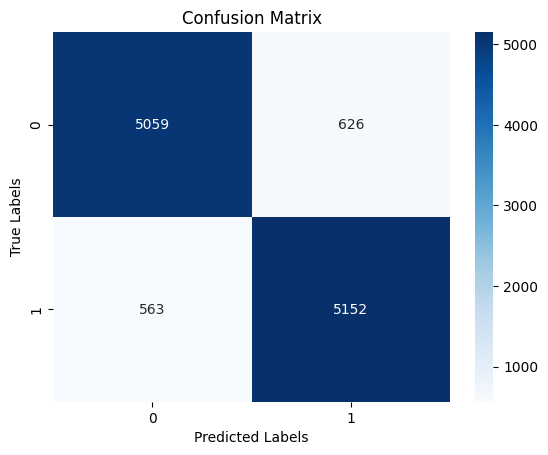

The accuracy score of val predictions: 0.8957017543859649


In [59]:
X_train_cm, X_val_cm, y_train_cm, y_val_cm = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=4)
"""
ada_classif_grid.fit(X_train_cm, y_train_cm)
y_pred_proba_cm = ada_classif_grid.predict_proba(X_val_cm)[:, 1]
"""
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), learning_rate=0.1, n_estimators= 200)
clf.fit(X_train_cm, y_train_cm)
y_pred_proba_cm = clf.predict_proba(X_val_cm)[:, 1]

y_true = y_val_cm
# Convert probabilities to binary predictions using the 0.5 threshold
y_pred = (y_pred_proba_cm > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f'The accuracy score of val predictions: {accuracy}')

Adaboost model achieved relatively high accuracy, correctly classifying a large number of samples as either malicious or non-malicious. However, it exhibited a notable number of false negatives and false positives. These misclassifications indicate areas where the model could be improved, particularly in correctly identifying malicious files. The precision metric highlights the importance of minimizing false positives, while the recall metric emphasizes the need to reduce false negatives.
However, the model is a bit more strict as we expected, because it is a classification of malicious files.

<u><font size=5>Feature Importance - AdaBoost Classifier</font></u><br>
This is a graph showing the features that contributed the most to the predictions of the AdaBoost Classifier model.<br>
The top three features are 'imports', 'printables' and the annonymous feature 'B'. Our own created 'size_ratio' came in not too far behind on fourth place, and 'avelength' is close in fifth. 

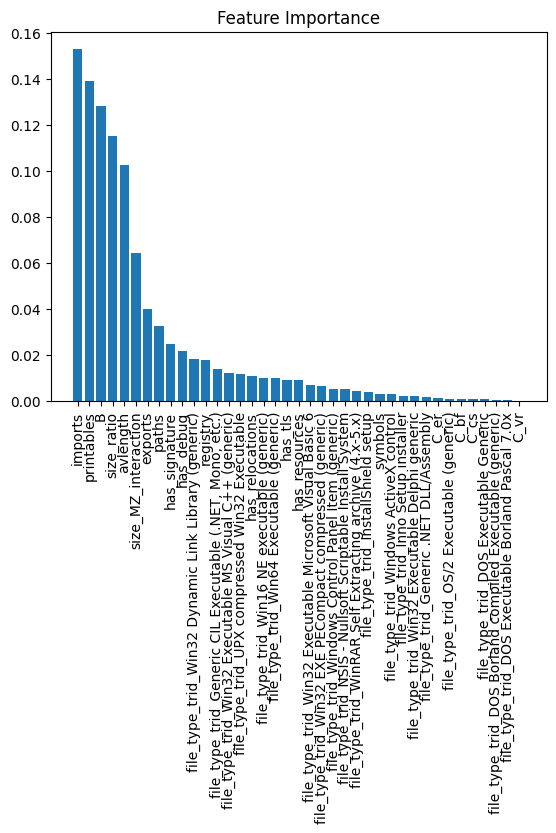

In [60]:
importances = []
"""
when doing grid.search:
estimators = ada_classif_grid.best_estimator_.estimators_

for estimator in estimators:
    if hasattr(estimator, 'feature_importances_'):
        importances.append(estimator.feature_importances_)

importances = np.array(importances)
importances = importances.reshape(-1, 1)
"""
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
names = [chosen_column_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_train_cm.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train_cm.shape[1]), names, rotation=90)
# Show plot
plt.show()


<u><font size=5>Extracting the predicted probabilities for the Test file to a CSV</font></u>

In [61]:
"""
model = AdaBoostClassifier(base_estimator = ada_classif_grid.best_params_['base_estimator'],
                           learning_rate = ada_classif_grid.best_params_['learning_rate'],
                           n_estimators = ada_classif_grid.best_params_['n_estimators'])
"""
#with the hyper parameters:
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=5), learning_rate = 0.1, n_estimators = 200)

model.fit(X_dataset, y_dataset)
predict_proba = model.predict_proba(test)

result = pd.DataFrame({'sha256': test_file_names, 'predict_proba' : predict_proba[:, 1]})    
result.to_csv('results_27.csv', index=False)

<u><font size=6>Pipeline Preperations</font></u><br>
<u><font size=5>Pipeline Functions:</font></u><br>
Running the code from this point down will load the functions and run the pipeline. 

In [2690]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tabulate import tabulate
from typing import List, Dict
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix, roc_curve, accuracy_score
from scipy.spatial.distance import mahalanobis

warnings.filterwarnings('ignore') #Ignroe warnings

In [2691]:
def load_data(file_name):
    dataset = pd.read_csv(file_name)
    return dataset

In [2692]:
def print_cv_clf(clf, X, y):

    fprs, tprs, thresholds, auc_scores_val, auc_scores_train = [], [], [], [], []

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')


    # Iterate over each fold and plot the ROC curve
    for i in range(5):
        X_train_i, X_val_i, y_train_i, y_val_i = train_test_split(X, y, test_size=0.2, random_state=i)

        clf.fit(X_train_i, y_train_i)
        y_pred_proba_cv_i = clf.predict_proba(X_val_i)[:, 1]
        X_pred_proba_cv_i = clf.predict_proba(X_train_i)[:, 1]

        # Calculate the ROC curve for the current fold
        fpr, tpr, threshold = roc_curve(y_val_i, y_pred_proba_cv_i) #For val
        # Calculate the AUC score for the current fold
        val_auc_score = roc_auc_score(y_val_i, y_pred_proba_cv_i)
        train_auc_score = roc_auc_score(y_train_i, X_pred_proba_cv_i)

        # Store the results for each fold
        fprs.append(fpr)
        tprs.append(tpr)
        thresholds.append(threshold)
        auc_scores_val.append(val_auc_score)
        auc_scores_train.append(train_auc_score)
        
        # Plot the ROC curve for the current fold
        plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f}) - Fold {}'.format(val_auc_score, i + 1))

    print("Validation Mean AUCs Score:", np.mean(auc_scores_val))
    print("Train Mean AUCs Score:", np.mean(auc_scores_train))
    plt.legend(loc='lower right', fontsize='small')
    plt.show()


In [2693]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    rss = np.sum((y-lr_model.predict(X))**2)
    return rss/(X.shape[0]-X.shape[1]-1)

def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    # train and predict using selected features
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    mse = mean_squared_error(y, lr_model.predict(X))

    # calculate cp
    n = X.shape[0]
    d = X.shape[1]
    cp = mse + sigma_hat_squared*2*((d+1)/n)
    return cp


def remove_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict:
    best_score = np.inf
    for i in range(len(current_features)):
    # remove feature
        potential_feature_lst = current_features.copy()
        potential_feature_lst.pop(i)
        potential_feature_arr = X[:,potential_feature_lst]
        #get mallows cp score
        model_score = get_mallows_cp_score(potential_feature_arr, y, sigma_hat_squared)
        # compare to best score
        if model_score < best_score:
            best_score = model_score
            best_features_lst = potential_feature_lst.copy()
            
    return {'features':sorted(best_features_lst),'score':best_score}

def backward_selection(X: np.array, y: np.array) -> List[int]:
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)
    # set initial features to all features
    current_features = list(range(X.shape[1]))
    models_lst = []
    #perform backward selection
    while len(current_features) > 1:
        # remove feature
        model = remove_feature(X, y, current_features, sigma_hat_squared)
        #update
        current_features = model['features']
        models_lst.append(model)

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)



In [2694]:
def fillna_champ(X ,dataset):
    X[to_zero] = X[to_zero].fillna(0)
    X[to_median] = X[to_median].fillna(dataset[to_median].median())
    X[to_mean] = X[to_mean].fillna(dataset[to_mean].mean())
    X['C'] = X['C'].fillna(dataset['C'].value_counts().idxmax())
    return X 

In [2695]:
def knn_champ(X, dataset):
    # Extract the columns from the dataset that require imputation
    columns_to_impute = ['size', 'vsize']
    # Initialize a dictionary to store the imputers
    imputers = {}
    # Iterate over each column to impute
    for column in columns_to_impute:
        # Create a KNNImputer object for the current column
        imputer = KNNImputer(n_neighbors=5)
        # Fit the imputer on the corresponding column values in dataset
        imputer.fit(dataset[[column]])
        # Store the imputer in the dictionary
        imputers[column] = imputer
        # Impute the missing values in X_train using the fitted imputer
        X[column] = imputer.transform(X[[column]])

    return X

In [2696]:
def encoder_champ(data):

    #one-hot encoding
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_cols = encoder.fit_transform(data[feat_cat])
    #Create a DataFrame from the encoded columns
    dummy_vars = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(feat_cat), index=data.index)
    #Drop the categorical columns
    data = data.drop(feat_cat, axis=1)
    #Add 'sha256' column as the first column
    dummy_vars.insert(0, 'sha256', data['sha256'])
    #Concatenate dummy variables and numeric columns
    new_data = pd.concat([dummy_vars, data.drop('sha256', axis=1)], axis=1)
    return new_data


In [2697]:
def removing_irrelevant_encoding_champ(X):
    X_columns = set(X.columns[:-1])
    for column in combined_list:
        if column not in X_columns:
            X[column] = 0
        
    # Count the number of values equal to 1 in each column of new_d[combined_list]
    counts = X[combined_list].sum(axis=0)
    # Drop columns with counts less than 0.00005*len(X)
    columns_to_drop = counts[counts < 0.00005*len(X)].index #if the colums does not have sample with 1 that 0.00005% from the data the column is not relevant 
    X.drop(columns_to_drop, axis=1, inplace=True)
    return X

In [2698]:
def transformation_champ(X):
    X['size_ratio'] = ((X['vsize'])) / (X['size'])
    X['size_MZ_interaction'] = X['size'] * X['MZ']

    X.drop('numstrings', axis = 1, inplace = True)
    X.drop('size', axis = 1, inplace = True)
    X.drop('vsize', axis = 1, inplace = True)
    X.drop('MZ', axis = 1, inplace = True)
    X.drop('file_type_prob_trid', axis = 1, inplace = True)
    if "label" in X.columns:
        label_column = X.pop('label')  # Remove the 'label' column from the DataFrame
        X['label'] = label_column  # Add the 'label' column back to the DataFrame at the end
    return X

In [2699]:
def remove_outliers_champ(X):
    #Compute the covariance matrix
    cov_matrix = np.cov(X.iloc[:,1:-1].T) #not including sha256 & label
    #Compute the inverse covariance matrix
    inverse_cov_matrix = np.linalg.inv(cov_matrix)
    #Calculate the Mahalanobis distance for each sample
    mean = np.mean(X.iloc[:,1:-1], axis=0)
    centered_data = X.iloc[:,1:-1] - mean
    mahalanobis_distances = np.sqrt(np.einsum('ij, ij -> i', np.dot(centered_data, inverse_cov_matrix), centered_data))

    #Detect outliers
    threshold = np.percentile(mahalanobis_distances, 95)  
    outlier_indices = np.where(mahalanobis_distances > threshold)[0]
    #Remove outliers from the data and labels
    filtered_data = X.drop(outlier_indices)
    
    return filtered_data

In [2700]:
def pre_processing(dataset, testset):
    global dataset_filling, feat_cat, feat_bin, feat_non_numeric, to_zero, to_median, to_mean
    
    feat_cat = ['file_type_trid', 'C']
    feat_bin = ['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']
    feat_non_numeric = feat_cat + feat_bin
    
    to_zero = ['has_debug', 'has_resources', 'has_relocations', 'has_tls', 'has_signature', 'registry', 'symbols']
    to_median = ['A', 'imports', 'exports', 'numstrings', 'avlength', 'MZ', 'paths','urls']
    to_mean = ['printables', 'B']
    
    #Splitting the data for dealing with outliers and fit the dimension reduction algoritm
    y = dataset['label']
    X = dataset.iloc[:,:-1]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    dataset_filling = dataset.copy()
    
    dataset = fillna_champ(dataset, dataset_filling)
    X_train = fillna_champ(X_train, dataset_filling)
    X_val = fillna_champ(X_val, dataset_filling)

    dataset = knn_champ(dataset, dataset_filling)
    X_train = knn_champ(X_train, dataset_filling)
    X_val = knn_champ(X_val, dataset_filling)
    
    #merging for deleting outliers (corresponding indices)
    y_train_df = y_train.to_frame().rename(columns={y_train.name: 'label'})
    merged_train = pd.merge(X_train, y_train_df, left_index=True, right_index=True)
    y_val_df = y_val.to_frame().rename(columns={y_val.name: 'label'})
    merged_val = pd.merge(X_val, y_val_df, left_index=True, right_index=True)

    global combined_list
    unique_file_type = 'file_type_trid_' + dataset[feat_cat[0]].unique()
    unique_C = 'C_' + dataset[feat_cat[1]].unique()
    unique_file_type = unique_file_type.tolist()
    unique_C = unique_C.tolist()
    combined_list = unique_file_type + unique_C
    combined_list = list(map(str, combined_list))
    
    #encoding
    dataset = encoder_champ(dataset) 
    merged_train = encoder_champ(merged_train) 
    merged_val = encoder_champ(merged_val)
    #delete irrelevant encoding features
    dataset = removing_irrelevant_encoding_champ(dataset)
    merged_train = removing_irrelevant_encoding_champ(merged_train)
    merged_val = removing_irrelevant_encoding_champ(merged_val)

    dataset = transformation_champ(dataset)
    merged_train = transformation_champ(merged_train)
    merged_val = transformation_champ(merged_val)
    
    global feat_numeric
    feat_numeric = ['size_ratio', 'imports', 'exports', 'paths', 'urls', 'printables', 'avlength', 'A', 'B', 'size_MZ_interaction', 'symbols', 'registry']

    scaler = MinMaxScaler()
    numeric_train_set_normalized = scaler.fit_transform(merged_train[feat_numeric])
    numeric_train_set_normalized = pd.DataFrame(numeric_train_set_normalized, columns=feat_numeric)

    numeric_val_set_normalized = scaler.fit_transform(merged_val[feat_numeric])
    numeric_val_set_normalized = pd.DataFrame(numeric_val_set_normalized, columns=feat_numeric)
    # The numeric_Val_set_normalized is at the moment type: Any, we decided no to turn it into a df

    numeric_dataset_normalized = scaler.fit_transform(dataset[feat_numeric])
    numeric_dataset_normalized = pd.DataFrame(numeric_dataset_normalized, columns=feat_numeric)
    
    merged_train = pd.DataFrame(merged_train).copy()
    merged_train = merged_train.reset_index(drop=True)
    merged_train[feat_numeric] = numeric_train_set_normalized[feat_numeric]

    merged_val = pd.DataFrame(merged_val).copy()
    merged_val = merged_val.reset_index(drop=True)
    merged_val[feat_numeric] = numeric_val_set_normalized[feat_numeric]

    dataset = pd.DataFrame(dataset).copy()
    dataset = dataset.reset_index(drop=True)
    dataset[feat_numeric] = numeric_dataset_normalized[feat_numeric]

    #remove outliers:
    dataset = remove_outliers_champ(dataset)
    merged_train = remove_outliers_champ(merged_train)
    
    X_dataset = dataset
    y_dataset = dataset['label']
    X_dataset.drop('label', axis=1, inplace=True)

    X_train = merged_train
    y_train = merged_train['label']
    X_train.drop('label', axis=1, inplace=True)

    X_val = merged_val
    y_val = merged_val['label']
    X_val.drop('label', axis=1, inplace=True)
    
    #dimension reduction:
    res = backward_selection(np.array(X_train.iloc[:, 1:]),np.array(y_train))
    global chosen_column_names
    chosen_column_names = list(X_train.columns[1:][res]) #the columns names
    columns_to_delete = set(X_dataset.columns) - set(X_train.columns)
    X_dataset.drop(columns=columns_to_delete, inplace=True)
    X_dataset = X_dataset[X_train.columns]
    X_dataset = np.array(X_dataset.iloc[:, 1:])[:,res] #without sha256
    

#Pre-processing for the test:
    test = pd.read_csv(testset)
    
    test = fillna_champ(test, dataset_filling)
    test = knn_champ(test, dataset_filling)
    test = encoder_champ(test)
    test = removing_irrelevant_encoding_champ(test)
    test = transformation_champ(test)
    
    numeric_test_normalized = scaler.fit_transform(test[feat_numeric])
    numeric_test_normalized = pd.DataFrame(numeric_test_normalized, columns=feat_numeric)
    test = pd.DataFrame(test).copy()
    test = test.reset_index(drop=True)
    test[feat_numeric] = numeric_train_set_normalized[feat_numeric]
    test_file_names = test['sha256'] #save the id column
    
    X_test_fix = test.copy()
    X_dataset_columns_fix = set(chosen_column_names)
    X_test_columns_fix = set(X_test_fix.columns)
    # Find the missing columns in X_val
    missing_columns = X_dataset_columns_fix - X_test_columns_fix 
    for column in missing_columns:
        X_test_fix[column] = 0
    # Reorder the columns in test_final to match the order of X_train
    X_test_fix = X_test_fix[chosen_column_names]
    test = np.array(X_test_fix) #without sha256

    return X_dataset, y_dataset, test, test_file_names


In [2701]:
def ada_model(X, y):
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), learning_rate=0.1, n_estimators= 200)

    print_cv_clf(clf, X, y)
    
    X_train_cm, X_val_cm, y_train_cm, y_val_cm = train_test_split(X, y, test_size=0.2, random_state=4)
    clf.fit(X_train_cm, y_train_cm)
    y_pred_proba_cm = clf.predict_proba(X_val_cm)[:, 1]
    y_true = y_val_cm
    # Convert probabilities to binary predictions using the 0.5 threshold
    y_pred = (y_pred_proba_cm > 0.5).astype(int)
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Plotting the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    print(f'The accuracy score of val predictions: {accuracy}\n')
    
    print(f'\nFeature Importance Plot:\n')
    importances = []
    importances = clf.feature_importances_

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    names = [chosen_column_names[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance")
    # Add bars
    plt.bar(range(X_train_cm.shape[1]), importances[indices])
    # Add feature names as x-axis labels
    plt.xticks(range(X_train_cm.shape[1]), names, rotation=90)
    # Show plot
    plt.show()

    
    return AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), learning_rate=0.1, n_estimators= 200)

In [2702]:
def pipeline(data_name, test_name):
    dataset = load_data(data_name)
    
    X, y, test, sha256 = pre_processing(dataset, test_name)
    print('\nChosen Model - AdaBoost Classifier:\n')
    model = ada_model(X, y)
    
    #Using the test:
    model.fit(X, y)
    predict_proba = model.predict_proba(test) 
    
    result = pd.DataFrame({'sha256': sha256, 'predict_proba' : predict_proba[:, 1]})    
    result.to_csv('results_27.csv', index=False)
    print("\nTest results file: 'results_27.csv' exported successfully")

<u><font size=5>Pipeline Activation</font></u>


Chosen Model - AdaBoost Classifier:

Validation Mean AUCs Score: 0.9596951944116292
Train Mean AUCs Score: 0.9821475790935971


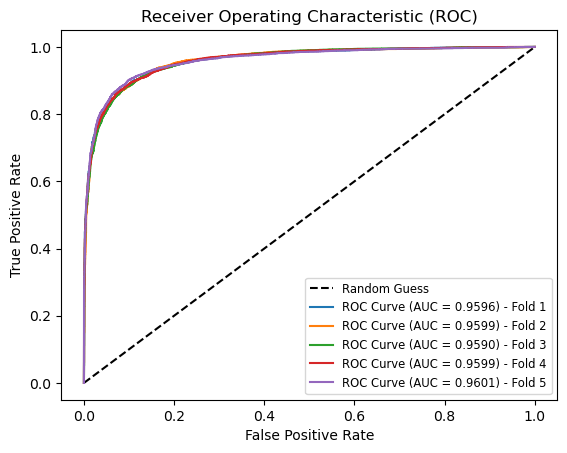

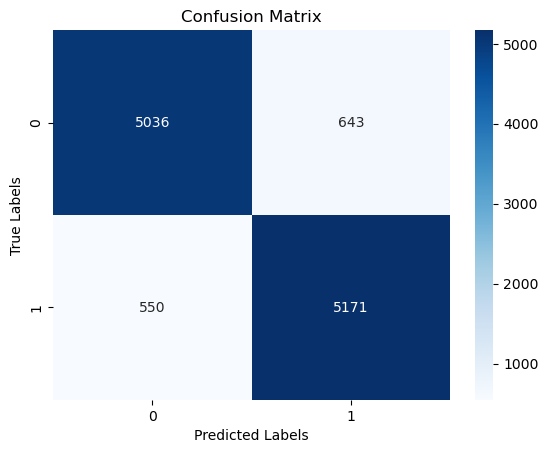

The accuracy score of val predictions: 0.8953508771929825


Feature Importance Plot:



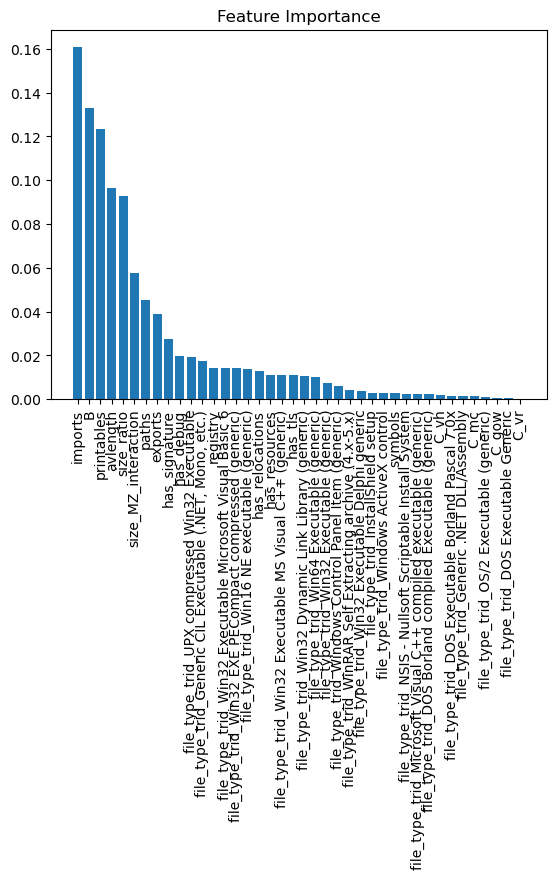


Test results file: 'results_27.csv' exported successfully


In [2703]:
pipeline('train.csv', 'test.csv')